In [14]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import scipy.stats as stats
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [15]:
rentals = pd.read_csv('formated_OutlierFixed.csv')
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          2448 non-null   int64  
 1   BedRooms       2448 non-null   float64
 2   SQFT           2448 non-null   float64
 3   BathRooms      2448 non-null   float64
 4   No_Smoke       2448 non-null   float64
 5   No_Park        2448 non-null   float64
 6   W_D_Lndry      2448 non-null   float64
 7   Pets           2448 non-null   float64
 8   Property_Type  2448 non-null   float64
 9   Log_Price      2448 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 191.4 KB


In [16]:
# slice data into features and target
X_orgi = rentals.drop(columns = ['Price','Log_Price'])
X_org = sm.add_constant(X_orgi)

y_org = rentals.loc[:, 'Price']

# fit model with target as housing price index 
log_model = sm.OLS(y_org, X_org, data=rentals) 

# fit our model 
results = log_model.fit()
results.summary()

/Users/stay_one/opt/anaconda3/envs/metis/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     425.4
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:17:32   Log-Likelihood:                -17636.
No. Observations:                2448   AIC:                         3.529e+04
Df Residuals:                    2439   BIC:                         3.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           877.2499     31.592     27.768      0.000     815.300     939.199
BedRooms         20.0333     15.522      1.291      0.197     -10.405      50.471
SQFT              1.0192      0.030     33.997      0.000       0.960       1.078
BathRooms        19.6725     18.799      1.046      0.295     -17.191      56.536
No_Smoke        -10.6360     14.517     -0.733      0.464     -39.102      17.830
No_Park        -240.1422    146.290     -1.642      0.101    -527.008      46.723
W_D_Lndry       296.9253     16.279     18.240      0.000     265.003     328.847
Pets            120.0385     15.228      7.883      0.000      90.177     149.900
Property_Type  -105.3038     24.706     -4.262      0.000    -153.751     -56.857
==============================================================================
Omnibus:                      496.485   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8903.910
Skew:                          -0.454   Prob(JB):                         0.00
Kurtosis:                      12.299   Cond. No.                     2.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


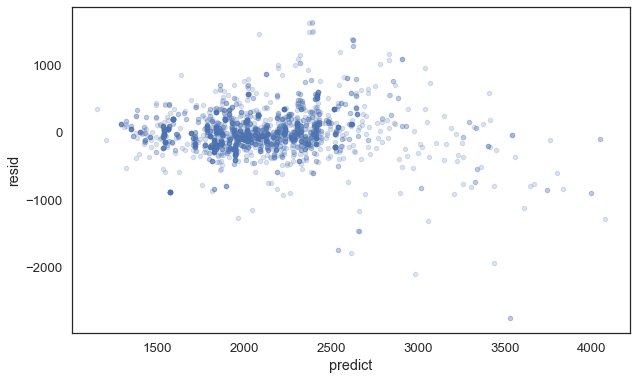

In [17]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
rentals['predict'] = results.predict(X_org)
rentals['resid'] = rentals.Price - rentals.predict
with sns.axes_style('white'):
    plot=rentals.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

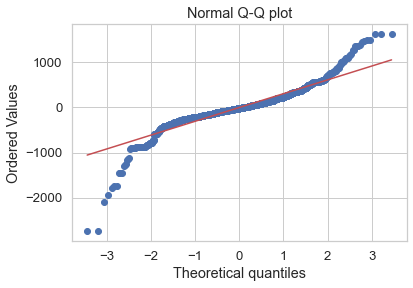

In [18]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(rentals['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

<AxesSubplot:>

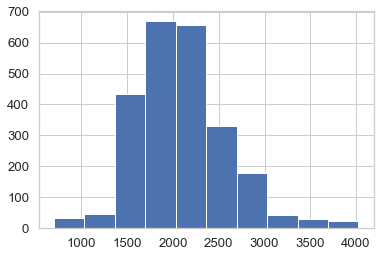

In [19]:
rentals.Price.hist()

<AxesSubplot:>

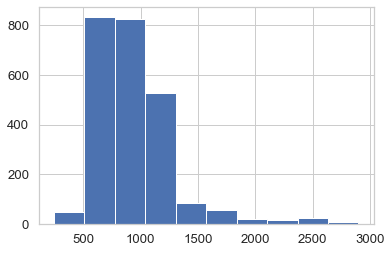

In [20]:
rentals.SQFT.hist()

In [ ]:
# try log transformation
np.log(rentals.SQFT).hist();


In [ ]:
rentals['Log_SQFT'] = np.log(rentals.SQFT)
rentals.info()

## Outliers & Leverage

In [21]:
influence = results.get_influence()
influence_frame = influence.summary_frame().reset_index()

In [22]:
influence_frame.head()

,index,dfb_const,dfb_BedRooms,dfb_SQFT,dfb_BathRooms,dfb_No_Smoke,dfb_No_Park,dfb_W_D_Lndry,dfb_Pets,dfb_Property_Type,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0,0.005616,-0.003542,-0.001215,0.002106,-0.004091,-0.001045,-0.010512,0.005070,0.001088,0.000023,0.276175,0.002712,0.014401,0.276122,0.014399
1,1,-0.001793,0.002249,0.004574,0.002149,0.008213,0.001010,-0.006881,-0.007366,-0.005737,0.000053,-0.583659,0.001388,-0.021757,-0.583580,-0.021754
2,2,0.227661,0.024772,-0.128434,0.049474,-0.067391,-0.001247,-0.067112,-0.078274,-0.159216,0.011027,-4.022520,0.006096,-0.315028,-4.035102,-0.316013
3,3,0.002430,0.009177,-0.001130,-0.011038,0.007751,-0.000057,0.005674,0.001072,-0.002542,0.000029,0.295447,0.002933,0.016024,0.295392,0.016021
4,4,-0.010614,0.002803,0.004860,-0.002191,-0.010689,0.000406,0.008467,0.010273,-0.000606,0.000038,-0.267546,0.004795,-0.018572,-0.267495,-0.018568


In [23]:
##Worry if Higher than 1 checking outliers and leverage points

In [24]:
influence_frame.cooks_d.sort_values(ascending=False).head()

349     0.203394
348     0.203394
512     0.056542
2166    0.039151
739     0.032588
Name: cooks_d, dtype: float64

In [25]:
influence_frame['cooks_d'].idxmax()

348

## VIF Collinerity

In [26]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['variables'] = X_org.columns
vif['vif'] =[variance_inflation_factor(X_org.values, i) for i in range(X_org.shape[1])]
vif


,variables,vif
0,const,22.969079
1,BedRooms,3.539127
2,SQFT,2.550333
3,BathRooms,2.753118
4,No_Smoke,1.082964
5,No_Park,1.003910
6,W_D_Lndry,1.109170
7,Pets,1.123016
8,Property_Type,1.429461


In [3]:
rentals.columns

Index(['Price', 'BedRooms', 'SQFT', 'BathRooms', 'No_Smoke', 'No_Park',
       'W_D_Lndry', 'Pets', 'Property_Type', 'Log_Price'],
      dtype='object')

In [4]:
# Split into train, val, and test
X, X_test, y, y_test = train_test_split(rentals[[ 'BedRooms', 'SQFT', 'BathRooms', 'No_Smoke', 'No_Park',
       'W_D_Lndry', 'Pets', 'Property_Type']], 
                                        rentals['Price'], test_size=0.2, random_state=9)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=9)


## Simple linear regression on training set and Val

In [5]:
# Fit a simple linear regression on training set
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.5520213777515619

In [6]:
# Score on validation set
lr.score(X_val,y_val)

0.6211840734292156

## Polynomial regression Degree 2 

In [7]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)


#Apply polynomial transofrmation to the train set
X_train_poly = poly.fit_transform(X_train)


# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)


# Apply polynomial transformation to test set
X_test_poly = poly.fit_transform(X_test)


# Fit a model using polynomial features
lr_poly = LinearRegression()

lr_poly.fit(X_train_poly,y_train)

lr_poly.score(X_train_poly,y_train)

0.6745565633045432

In [8]:
# Score on validation set
lr_poly.score(X_val_poly, y_val)

0.6654865027246821

In [ ]:
list(zip(poly.get_feature_names([ 'BedRooms', 'SQFT', 'BathRooms', 'No_Smoke', 'No_Park',
       'W_D_Lndry', 'Pets', 'Property_Type']),lr_poly.coef_))

## LassoCV, to a get a model that minimizes errors while keeping the model as simple as possible.

In [9]:
# Don't forget to standard scale your data for regularized regression
scaler = StandardScaler()


#Apply polynomial transofrmation to the train set
X_train_poly_scaled = scaler.fit_transform(X_train_poly)


# Apply the same scaler to val set
X_val_poly_scaled = scaler.transform(X_val_poly)


# Apply the same scaler to val set
X_test_poly_scaled = scaler.transform(X_test_poly)


# Fit a LASSO model using polynomial features
lasso = LassoCV()

lasso.fit(X_train_poly_scaled,y_train)

lasso.score(X_train_poly_scaled,y_train)

/Users/stay_one/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e+05, tolerance: 3.550e+04
  model = cd_fast.enet_coordinate_descent(


0.6713568365090978

In [10]:
# Score on validation set
lasso.score(X_val_poly_scaled, y_val)

0.6709236482600043

In [ ]:
list(zip(poly.get_feature_names(['SQFT', 'Property_Type','BedRooms', 'BathRooms', 'W_D_Lndry','Pets']),lasso.coef_))

## Ridge Regression

In [11]:
## alphas for the Ridge Cross Validation method to evaluate
alphavec = 10**np.linspace(-2,2,500)

ridge_model = RidgeCV(alphas=alphavec, cv=3)
ridge_model.fit(X_train_poly_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=3)

In [12]:
rid_alpha = ridge_model.alpha_
rid_alpha

1.9256135721291967

In [13]:
rid = Ridge(alpha=rid_alpha)
rid.fit(X_train_poly_scaled, y_train)

print(f'Ridge Regression train R^2: {rid.score(X_train_poly_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_poly_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_poly_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_poly_scaled), squared=False):.5f}')



Ridge Regression train R^2: 0.67352
Ridge Regression val R^2: 0.66770

Ridge Regression RMSE (train): 280.99719
Ridge Regression RMSE (val): 303.69173
